# Fly Flip Notebook

This notebook allows a user to input their data path and generate an average mask of the fly for that experiment. Using this mask the computed orientation will be checked, and if needed realigned. As a result a new text file will be generated of angles that are more representative of the fly's pose. Finally, figures comparing the significance in the change can be developed.

This entire process can be automatically performed, see the library's documentation for how to do so.

Phases:
1. Import Depandencies
2. Set Data Source
3. Perform Image Labeling
    - Currently using OpenCV Method
    - Next Method: Using Tkinter GUI
4. Development of Average Mask
5. MSE Comparison
6. Plot of MSE

## Import Libraries

In [ ]:
# Import Libraries
import sys
import os
import random
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cv2
import copy
import glob
import tkinter as tk
current_dir = os.path.dirname(os.getcwd())
print(current_dir)
# plot_dir = os.path.join(current_dir,'plotting')
sys.path.append(current_dir)
# print(sys.path)
# Import libraries regarding the trace...
from flyplot.parsing.exact_exp_groups import sub_exp_groupv2  # more dataparsing methods
from flyplot.led_convert import get_LED_angle_in_rad
from flyplot.plotting import polarplot as polarplt # polar plotting module
from flyplot.led_convert import get_LED_angle_in_rad
from flyplot.plotting.flyviz import get_objectmask, contour_hrz_matrix
from flyplot.data.data_loader import data_loader
from flyplot.fly_analysis.compare import mse, data_mse, img_label
from flyplot.parsing import fly_wrap
# import example data
# from scipy import interpolate
from find_fly_angle.find_fly_anglev2 import *

## Set Data Source

Provide path to the image and text dataset that will be referenced throughout this notebook.

Examples:

* MacOS
    
    `data = glob.glob('/Volumes/No Name/20240502125110/*.png')`

* Windows

    `data = glob.glob('D:/20240502125110/*.png')`
    
    
* Linux

    `data = glob.glob('/media/user_name/D5E2-7968/20240502125110/*.png')`

In [4]:
imgs_source = '/media/loganrower/D5E2-7968/20240502125110/*.png'

In [5]:
txt_source = '/media/loganrower/D5E2-7968/20240502125110_data/20240502125110.txt'

In [ ]:
exp_date = None

In [6]:
# Path to Image Dataset
img_data = glob.glob(imgs_source)
# Path to Text Data
txt_data = txt_source  

Determine the number of images in the dataset

In [7]:
len(img_data)

8862

## (Optional) Test Image

To ensure that all dependancies are working appropriately, an image source internally within this package will be used to test the `contour_hrz_matrix` method.

Alternatively, you can utilize a different image.

In [ ]:
# Load in Example Data:
sample_figs = data_loader()['figs']
sample_imgs = data_loader()['imgs']
sample_raw_dat =data_loader()['raw_data']
# Example Image:
file = '20240502125110_7355' # 5244
file_name = None
for img in sample_imgs:
    if  os.path.basename(img).strip('.png') == file:
        file_name = img
# file ="20240415120905_0121" 
# file_name = "imgs/" + file +".png"
fly_mask_orig, fly_mask_hrz,max_contour_hrz,centroid_hrz, body_axis_pt_0_hrz,body_axis_pt_1_hrz, angle_og, angle_rot = contour_hrz_matrix(file_name)


In [ ]:
plt.figure(figsize=(20,20))
mask_fly = get_objectmask(fly_mask_hrz,max_contour_hrz)

cv2.circle(mask_fly,body_axis_pt_0_hrz,10, color = (255,255,0),thickness =3)
cv2.circle(mask_fly,body_axis_pt_1_hrz,10, color = (255,255,0),thickness =3)
cv2.line(mask_fly,body_axis_pt_0_hrz,body_axis_pt_1_hrz,color = (255,255,0), thickness = 2)
cv2.circle(mask_fly,centroid_hrz,10,color = (0,255,255),thickness=3)
plt.imshow(mask_fly)

## Labeling
After verifying that your dependancies are working, proceed to label 20 random images of flies from the path provided initially. The labeling process is to assign each image an indication of whether or not the Non Rotated or Rotated image best represents a Fly.

Three Images will be displayed, with the first image represeting the original fly orientation, the second the rotated and transformed fly based on it's orientation (which will allow it to be oriented along the central vertical axis). The last image is a subsequent 180 degree rotation of the fly after the initial rotation and transformation....

Essentially the labeling is a selection between the last two images. After making this selection that image will be saved in order to generate an average mask.

The Criteria for Labeling:
- Fly head facing up in an image then use the respective 'n' or 'r' to assign that image to the fly. with `n` corresponding to `No Rotation` and `r` corresponding to `Rotation`

In [ ]:
imgs = {}
# get all of the files in the folder
shuffled_list = sorted(img_data , key=lambda x: random.random())
print(shuffled_list)
for file in shuffled_list[:20]:
    name = file.split('/')[-1].strip('.png')
    mask_fly = img_label(file)
    imgs[name] = mask_fly
    # execute function and then add these images and etc to the dictionary

## Average Fly Mask Template 
Using the 20 labelled images, a grayscale template mask will be developed of the fly facing upward. This average mask will then be tested against all images in the dataset to determine correct orientation.

In [ ]:
### Now with all the images we will create a mean tempate mask
final = []
for img in imgs.keys():
    final.append(imgs[img])
# print(final)
stacked = np.stack(final,axis=-1)
avg_mask = np.mean(stacked, axis = -1)
plt.figure(figsize=(20,20))
plt.imshow(avg_mask,cmap = 'gray')

## MSE Comparison
The entire image dataset will be tested against this average mask to determine the correct orientation of the fly. The MSE Rot and MSE No Rot will be logged as well as whether fly is No Rot or Rot.

In [ ]:
imgs[list(imgs.keys())[0]].dtype
img1 = imgs[list(imgs.keys())[18]].astype('float64')
error = mse(avg_mask,img1)
error2 = mse(avg_mask,cv2.rotate(img1,cv2.ROTATE_180))
print("No rotation:",error)
print("Rotation:",error2)

In [ ]:
img_path = np.random.choice(img_data)
# img_path = ('/media/loganrower/D5E2-7968/20240502125110/20240502125110_7355.png')
fly_mask_orig1, fly_mask_hrz1,max_contour_hrz,centroid_hrz, body_axis_pt_0_hrz,body_axis_pt_1_hrz,angle_og,angle_rot= contour_hrz_matrix(img_path)
img1 = fly_mask_hrz1.astype('float64')
error = mse(avg_mask,img1)
error2 = mse(avg_mask,cv2.rotate(img1,cv2.ROTATE_180))
print("------------")
print(angle_og)
print(np.rad2deg(angle_og))
print(polarplt.deg360to180(np.rad2deg(angle_og)-180))
print(angle_rot)
print(np.rad2deg(angle_rot))


In [ ]:
mask_fly_rot1 = cv2.rotate(copy.deepcopy(fly_mask_hrz1),cv2.ROTATE_180)

fig = plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(fly_mask_orig1,cmap='gray')
print(f"<< Original Angle: {np.rad2deg(angle_og)} >>")
plt.subplot(1,3,2)
plt.title("No Rotation")
# print("No Rotation Angle:",np.rad2deg(angle))
print(f"<< No Rotation Angle: {np.rad2deg(angle_og)} >>")
plt.imshow(fly_mask_hrz1,cmap='gray')
plt.subplot(1,3,3)
plt.title("Rotation")
print(f"<< Rotation Angle: {polarplt.deg360to180(np.rad2deg(angle_og)-180)} >>")
plt.imshow(mask_fly_rot1,cmap='gray')
plt.show()

In [ ]:
print("No rotation:",error)
print("Rotation:",error2)

The `data_mse` function can take from 10-15 min based on size of the dataset.

In [ ]:
results = data_mse(img_data,avg_mask)
results

The dictionary is then transformed into a dataframe for additional processing and subsequent plotting

In [ ]:
results_df = pd.DataFrame(results)
results_df.head()

# Plot all data

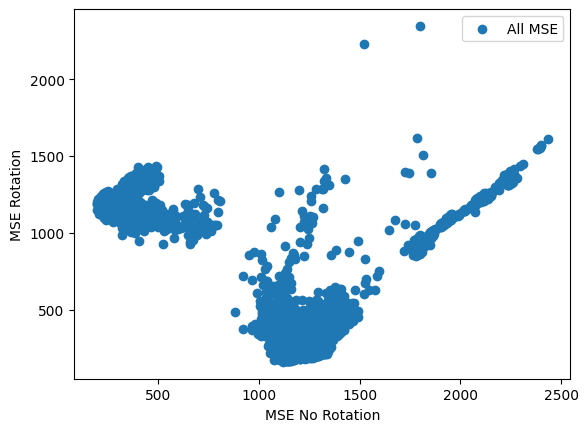

In [25]:
max_norot= max(list(map(lambda t:t[0],results_df['MSE'])))
max_rot = max(list(map(lambda t:t[1],results_df['MSE'])))
plt.scatter(results_df['MSE'].apply(lambda x: x[0]),results_df['MSE'].apply(lambda x: x[1]),label = 'All MSE')
plt.plot(np.arange(max((max_norot,max_rot))+1),np.arange(max((max_norot,max_rot))+1),color = 'k')
plt.xlabel('MSE No Rotation')
plt.ylabel('MSE Rotation')
plt.legend()
plt.savefig('figs/MSE_norotvrot.png')

## Plot of MSE ERROR No Rotation vs Rotation for Large Dataset

Using the average mask from before we will now look at all the images in the dataset to determine accuracy. 

In [ ]:
# Plot Type MSE NO ROTATION with VALUE MSE (X AXIS)
mse_norot = results_df[results_df['type']=='MSE No Rotation']
print(mse_norot)
mse_rot = results_df[results_df['type']=='MSE Rotation']
print(mse_rot)

In [ ]:
max_norot= max(list(map(lambda t:t[0],results_df['MSE'])))
max_rot = max(list(map(lambda t:t[1],results_df['MSE'])))
plt.scatter(mse_norot['MSE'].apply(lambda x: x[0]),mse_norot['MSE'].apply(lambda x: x[1]),label = 'Class: No Rotation')
plt.scatter(mse_rot['MSE'].apply(lambda x: x[0]),mse_rot['MSE'].apply(lambda x: x[1]),label = 'Class: Rotation')
plt.plot(np.arange(max((max_norot,max_rot))+1),np.arange(max((max_norot,max_rot))+1),color = 'k')
plt.xlabel('MSE No Rotation')
plt.ylabel('MSE Rotation')
plt.legend()
plt.savefig('figs/MSE_norotvrot_classes.png')

# Original Fly Trace

In [ ]:
# data source
print("Does the text file exist: ",os.path.exists(txt_data))
# female fly heading and led position data
df_fem_static = pd.read_csv(txt_data , names = ['time','fly heading','led position'],sep = " ")
# compute change over time
df_fem_static['delta-t'] = df_fem_static['time'] - df_fem_static['time'][0] 
# compute LED position in degrees
df_fem_static['led angle'] = np.rad2deg(get_LED_angle_in_rad(df_fem_static['led position'])) 
# get the experimental sub groups
fly_dict = sub_exp_groupv2(df_fem_static)
fly_dict



In [ ]:
plt.figure(figsize=(36,12))
# iterate over the sections
for k in list(fly_dict.keys()):
    start = fly_dict[k][0]
    end = fly_dict[k][1]
    # print(start,end)
    plt.plot(df_fem_static['delta-t'][start:end],df_fem_static['fly heading'][start:end],color = 'tab:blue', linewidth = .5, label = 'Heading')
    plt.plot(df_fem_static['delta-t'][start:end+1],df_fem_static['led angle'][start:end+1],color = 'tab:red', linewidth = 1, label = 'LED')
plt.title("Female Fly 20231228154547")
plt.xlabel("time")
plt.ylabel("Heading/LED Angle")
plt.savefig(f'figs/{exp_date}_Heading_LEDvSec.png')
plt.savefig(f'figs/{exp_date}_Heading_LEDvSec.svg')

# Reestablish a new Textfile 
dataframe to textfile

In [ ]:
# To the dataframe add the LED positions and the time values from the original textfile...
led_pos = df_fem_static['led position']
time_txt = df_fem_static['time']
results_df = results_df.sort_values(by='file')
results_df =results_df.reset_index(drop = True)
# Sort by time
results_df


In [29]:
# Time, Angle, Led Position
results_df['time'] = time_txt
results_df['led position'] = led_pos
# Rewrite
results_df.to_csv(f'revised_{exp_date}.txt',sep=' ', header=False)

In [ ]:
# data source
data_revised =f'revised_{exp_date}.txt'
# female fly heading and led position data
df_fly_revised= pd.read_csv(data_revised, names = ['filename','type','MSE','Original Angle','Adjusted Angle','time','led position'],sep = " ")

# compute change over time
df_fly_revised['delta-t'] = df_fly_revised['time'] - df_fly_revised['time'][0] 

# compute LED position in degrees
df_fly_revised['led angle'] = np.rad2deg(get_LED_angle_in_rad(df_fly_revised['led position'])) 

fly_dict_revised = sub_exp_groupv2(df_fly_revised)
fly_dict_revised

In [ ]:
# plotting the revised textfile
plt.figure(figsize=(36,12))
# iterate over the sections
for k in list(fly_dict_revised.keys()):
    start = fly_dict_revised[k][0]
    end = fly_dict_revised[k][1]
    # original textfile data
    # plt.plot(df_fem_static['delta-t'][start:end],df_fem_static['fly heading'][start:end],color = 'tab:green', linewidth = .8, label = 'Heading')
    # revised data
    plt.plot(df_fly_revised['delta-t'][start:end],df_fly_revised['Adjusted Angle'][start:end],color = 'tab:blue', linewidth = .8, label = 'Heading')
    plt.plot(df_fly_revised['delta-t'][start:end+1],df_fly_revised['led angle'][start:end+1],color = 'tab:red', linewidth = 1, label = 'LED')
plt.title("Revised Fly Orientation")
plt.xlabel("Time")
plt.ylabel("Heading/LED Angle")
plt.yticks(np.arange(-180,181,90))
plt.savefig(f'figs/{exp_date}_AdjHeading_LEDvSec.png')
plt.savefig(f'figs/{exp_date}_AdjHeading_LEDvSec.svg')

# New vs Original Plot

In [ ]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(36,18))

# Main Plot 
# ax1.plot(df_fly_revised['delta-t'],df_fly_revised['Original Angle'],color = 'k', linewidth = .5, label = 'Heading')
ax1.plot(df_fem_static['delta-t'],df_fem_static['fly heading'],color = 'k', linewidth = .5, label = 'Heading')
ax1.plot(df_fem_static['delta-t'],df_fem_static['led angle'],color = 'goldenrod', linewidth = 1, label = 'LED')
ax1.set_title("Fly Trace Original")
ax1.set_xlabel("time")
ax1.set_ylabel("Heading/LED Angle")
ax1.set_yticks(np.arange(-180,181,90))
ax1.legend(loc = "lower right")

# Offset
ax2.plot(df_fly_revised['delta-t'],df_fly_revised['Adjusted Angle'],color = 'k', linewidth = .5, label = 'Heading')
ax2.plot(df_fly_revised['delta-t'],df_fly_revised['led angle'],color = 'goldenrod', linewidth = 1, label = 'LED')
ax2.set_title("Adjusted Fly Trace")
ax2.set_xlabel("time")
ax2.set_ylabel("Heading/LED Angle")
ax2.set_yticks(np.arange(-180,181,90))
ax2.legend(loc = "lower right")

# Save Figure
plt.savefig(f'figs/{exp_date}_OG_AdjHeading.png',facecolor = 'white')
plt.savefig(f'figs/{exp_date}_OG_AdjHeading.svg',facecolor = 'white')

## Ensure that Original and Adjusted Headings Account for the Wrapping Affect...

In [ ]:
fly_wrap.wrapping_fix(exp_date, df_fem_static,df_fly_revised)